# Usando _Transfer Learning_ em uma Rede de Convolução
## Trabalho Prático 2 - Aprendizado de Máquina
### Departamento de Ciência da Computação - Universidade Federal de Minas Gerais

* Aluna: Maria Luísa Costa Pinto (https://malu.dev)
* Matrícula: 2018664772


## Introdução

Neste trabalho será aplicados os conceitos de _Convolutional Neural Networks_ (CNN) e de _Transfer Learning_. Serão aplicadas e comparadas 3 estratégias em um problema de classificação de imagens. 

No aprendizado profundo, uma rede neural convolucional (CNN ou ConvNet) é uma classe de redes neurais profundas, mais comumente aplicada à análise de imagens visuais.

CNNs são versões regularizadas de perceptrons multicamadas. Os perceptrons multicamadas geralmente se referem a redes totalmente conectadas, ou seja, cada neurônio de uma camada é conectado a todos os neurônios da camada seguinte. A "conectividade total" dessas redes as torna propensas a superdimensionar dados. Formas típicas de regularização incluem adicionar alguma forma de medição de magnitude de pesos à função de perda. No entanto, as CNNs adotam uma abordagem diferente em relação à regularização: aproveitam o padrão hierárquico em dados e montam padrões mais complexos usando padrões menores e mais simples. Portanto, na escala de conectividade e complexidade, as CNNs estão no extremo inferior.

_Transfering Learning_ é um problema de pesquisa em aprendizado de máquina que se concentra em armazenar o conhecimento adquirido ao resolver um problema e aplicá-lo a um problema diferente, mas relacionado. Por exemplo, o conhecimento adquirido ao aprender a reconhecer carros poderia se aplicar ao tentar reconhecer caminhões. Esta área de pesquisa tem alguma relação com a longa história da literatura psicológica sobre transferência de aprendizagem, embora os laços formais entre os dois campos sejam limitados.

## Bibliotecas necessárias

In [1]:
#
#  Importação das bibliotecas necessárias
#

import matplotlib as mpl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Markdown
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras import datasets
from keras import layers
from keras import optimizers
from keras import models
from keras.layers import Dense, Dropout, Activation, Conv2D, MaxPooling2D, Flatten
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils, plot_model
from IPython.display import Image

def printmd(s):
    display(Markdown(s))

Using TensorFlow backend.


## Declaração de constantes

Foi fixado o valor das épocas que os modelos irão treinar

In [0]:
NUM_EPOCHS = 20 

## Base de dados


Foi utilizado o conjunto de dados CIFAR-10. O conjunto de dados CIFAR-10 consiste em 60000 imagens coloridas de 32x32 em 10 classes, com 6000 imagens por classe. Existem 50000 imagens de treinamento e 10000 imagens de teste.

O conjunto de dados é dividido em cinco lotes de treinamento e um lote de teste, cada um com 10000 imagens. O lote de teste contém exatamente 1.000 imagens selecionadas aleatoriamente de cada classe. Os lotes de treinamento contêm as imagens restantes em ordem aleatória, mas alguns lotes de treinamento podem conter mais imagens de uma classe do que outra. Entre eles, os lotes de treinamento contêm exatamente 5000 imagens de cada classe.

Fonte: https://www.cs.toronto.edu/~kriz/cifar.html

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 10s 0us/step


## Conhecendo os dados

Abaixo são mostradas algumas informações e amostras do dados, a fim de conhece-los.

In [4]:
#
#  Exibição de informações sobre os dados
#

print("Forma dos dados de treinamento:")
print(x_train.shape)
print(y_train.shape)
print("Forma dos dados de teste:")
print(x_test.shape)
print(y_test.shape)

Forma dos dados de treinamento:
(50000, 32, 32, 3)
(50000, 1)
Forma dos dados de teste:
(10000, 32, 32, 3)
(10000, 1)


In [0]:
#
# declaracao do nome das classes encontradas no dataset
#

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Foi criada uma função para mostrar as partes dos dados:

In [0]:
#
#  Funcao que exibe uma amostra aleatoria dos dados
#
#  :paramêtro x: a parte X da base de dados inicial, as imagens
#  :paramêtro y: a parte y da base de dados inicial, as classes das palavras
#  :paramêtro sz: quantas imagens serão mostradas
#

def show_sample(x, y, sz):
  f, axarr = plt.subplots(1, sz)
  f.set_size_inches(24, 6)
  
  for i, j in zip(range(sz), y[0:sz]):
      img = x[i]
      axarr[i].imshow(img)
      axarr[i].set_title(str(cifar_classes[j[0]]))
  plt.show()

### Amostra da base de dados

Abaixo é mostrada uma amostra da base de dados

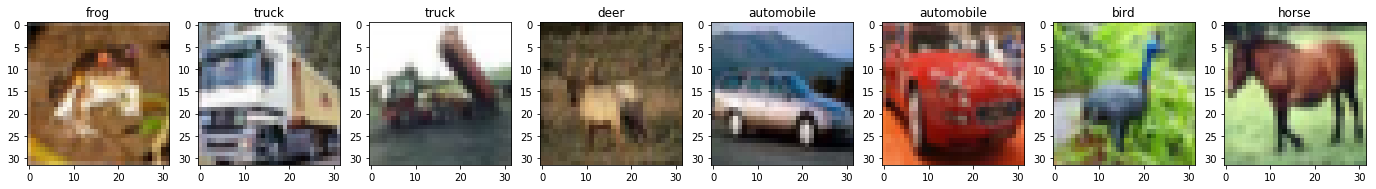

In [7]:
show_sample(x_train, y_train, 8)

## Separação dos dados em duas partes

Conforme definido no enunciado deste trabalho a base de dados foi dividida em duas partes: a parte A e a parte B, definidas pelo número de matrícula de cada aluno que no meu caso é **2018664772**.

In [0]:
#
#  Funcao que gera cada parte separada
#
#  :paramêtro x: a parte X da base de dados inicial, as imagens
#  :paramêtro y: a parte y da base de dados inicial, as classes das palavras
#  :paramêtro array_classes: o array que vai definir cada classe
#
#  : retorna a partição X e y de cada parte enviada à função
#

def generate_part_by_classes(x, y, array_classes):
  y = np.array(y_train)
  pos_i = np.argwhere(y == array_classes)
  pos_i = list(pos_i[:,0])
  x_i = [x_train[j] for j in pos_i]
  y_i = [y_train[j] for j in pos_i]  
  return x_i, y_i

Definindo a parte A e a parte B:

In [0]:
# Arrays que irão determinar as classes contidas em cada parte dos dados
array_a = (0, 1, 3, 4, 5, 6, 8, 9)
array_b = (2, 7)

# Definição das variáveis das partes, seguindo a regra contida na especificação

x_train_a, y_train_a = generate_part_by_classes(x_train, y_train, array_a)
x_test_a, y_test_a = generate_part_by_classes(x_test, y_test, array_a)

x_train_b, y_train_b = generate_part_by_classes(x_train, y_train, array_b)
x_test_b, y_test_b = generate_part_by_classes(x_test, y_test, array_b)

### Amostra da parte A

Abaixo são mostradas imagens das classes contidas na parte A.

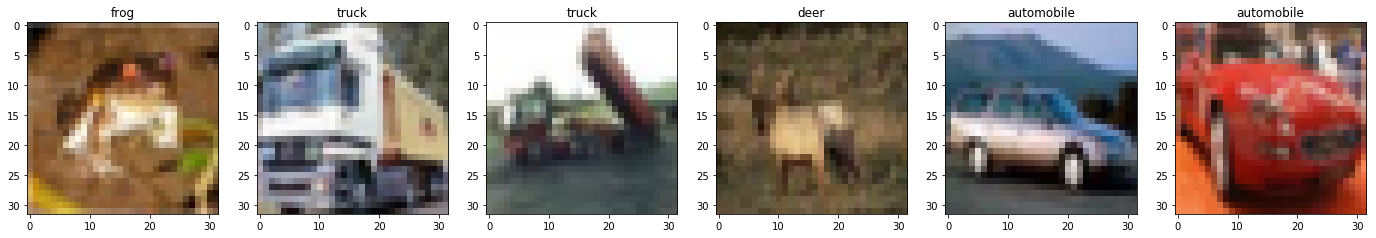

In [10]:
show_sample(x_train_a, y_train_a, 6)

### Amostra da parte B

Abaixo são mostradas imagens das classes contidas na parte B.

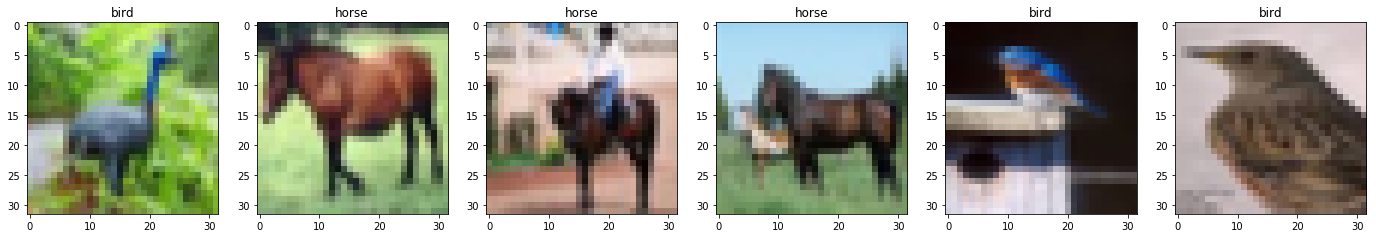

In [11]:
show_sample(x_train_b, y_train_b, 6)

## Preparando os dados


Foram realizadas algumas tranformações e notmalizações para que os dados estivessem prontos para a rede neural.

In [0]:
#
# Transformação dos índices de etiqueta em vetores codificados
#

y_train_a = to_categorical(y_train_a, num_classes=10)
y_test_a = to_categorical(y_test_a, num_classes=10)

y_train_b = to_categorical(y_train_b, num_classes=10)
y_test_b = to_categorical(y_test_b, num_classes=10)


x_train_a = np.array(x_train_a, dtype='float32')
x_test_a = np.array(x_test_a, dtype='float32')

x_train_b = np.array(x_train_b, dtype='float32')
x_test_b = np.array(x_test_b, dtype='float32')

#
# Normalização da intensidade dos pixels para o intervalo [0, 1]
#

x_train_a /= 255
x_test_a /= 255

x_train_b /= 255
x_test_b /= 255

#
# Pega o número de classes
#

n_classes = y_train_a.shape[1]
n_classes = y_train_b.shape[1]

## Gráficos e visualizações

Abaixo são definidas funções que geram gráficos e visões que serão utilizadas em todos os modelos desenvolvidos.


### Visualização da perda e da acurácia ao longo do tempo

A primeira visualização é referente à variação da função de perde e da medida da acurácia ao longo do tempo

In [0]:
def show_charts(h):
  acc = h.history['acc']
  val_acc = h.history['val_acc']
  loss = h.history['loss']
  val_loss = h.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training acc')
  plt.plot(epochs, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

### Visualização do modelo

A segunda função exibe um resumo do modelo.

In [0]:
def show_model(mdl, n_mdl):
  print("Resumo do modelo " + n_mdl)
  # Resumo dos modelos
  mdl.summary()

  # Visualize model architecture
  plot_model(mdl, to_file='model_structure'+ n_mdl +'.png', show_shapes=True)
  Image(filename='model_structure'+ n_mdl +'.png')

## Primeiro modelo

### Treinando os pesos com a classe A

Este modelo consiste em uma CNN para classificação das imagens usando os dados da parte A. A CNN contém 4 camadas de convolução, duas camadas de Max Pooling e duas camadas Fully Connected ao final. A ReLU foi usada como função de ativação, exceto na última camada, em que foi utilizada a função Softmax. O recurso do Dropout foi usado para regularizar a rede. 


In [15]:
#
# Declaração do modelo 1
#

model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv_1'))
model_1.add(Conv2D(32, (3, 3), activation='relu', name='conv_2'))
model_1.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling_1'))
model_1.add(Dropout(0.3))

model_1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), name='conv_3'))
model_1.add(Conv2D(32, (3, 3), activation='relu', name='conv_4'))
model_1.add(MaxPooling2D(pool_size=(2, 2), name='max_pooling_2'))
model_1.add(Dropout(0.3))

model_1.add(Flatten())
model_1.add(Dense(256, activation='relu', name="fully_conected_1"))
model_1.add(Dropout(0.3))

model_1.add(Dense(10, activation='softmax', name="fully_conected_2"))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_1.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)


W0701 05:51:17.441899 140158431299456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 05:51:17.475814 140158431299456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 05:51:17.481314 140158431299456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0701 05:51:17.518480 140158431299456 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0701 05:51:17.522631 140158431299456 deprecation_wrapp

### Treinando a CNN com a parte A

In [17]:
history_a = model_1.fit(x_train_a, y_train_a, batch_size=32, epochs=NUM_EPOCHS, validation_data=(x_test_a, y_test_a))

W0701 05:52:46.015246 140158431299456 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples, validate on 40000 samples
Epoch 1/20
40000/40000 [==============================] - 13s 320us/step - loss: 1.5846 - acc: 0.3786 - val_loss: 1.2733 - val_acc: 0.5160
Epoch 2/20
40000/40000 [==============================] - 9s 225us/step - loss: 1.2057 - acc: 0.5390 - val_loss: 1.0083 - val_acc: 0.6236
Epoch 3/20
40000/40000 [==============================] - 9s 223us/step - loss: 1.0788 - acc: 0.5925 - val_loss: 0.9154 - val_acc: 0.6584
Epoch 4/20
40000/40000 [==============================] - 9s 222us/step - loss: 0.9899 - acc: 0.6330 - val_loss: 0.8312 - val_acc: 0.6918
Epoch 5/20
40000/40000 [==============================] - 9s 219us/step - loss: 0.9234 - acc: 0.6565 - val_loss: 0.7455 - val_acc: 0.7266
Epoch 6/20
40000/40000 [==============================] - 9s 224us/step - loss: 0.8678 - acc: 0.6813 - val_loss: 0.7728 - val_acc: 0.7111
Epoch 7/20
40000/40000 [==============================] - 9s 227us/step - loss: 0.8221 - acc: 0.6967 - val_loss: 0.6445 -

Salva os pesos aprendidos em um arquivo para utilizar depois.

In [0]:
#
# Salva os pesos aprendidos na rede em um arquivo
#
model_1.save_weights('part_a_weights.h5')

### Visualizando os resultados do modelo 1

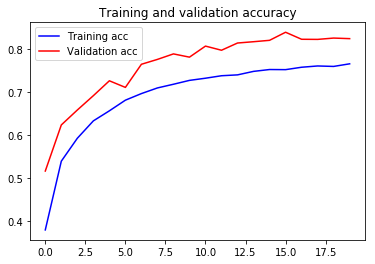

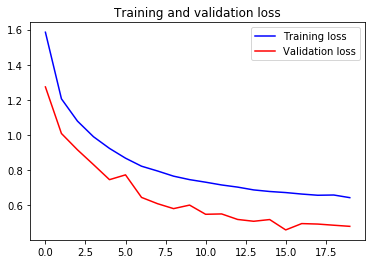

In [19]:
#
#  Mostra a variação da perda e da acurária ao longo das épocas
#

show_charts(history_a)

In [20]:
#
# Visualização do modelo 1
# 

show_model(model_1, '1')

Resumo do modelo 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 32)        9248      
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 5, 5, 32)          0 

## Segundo modelo 
### Treinar a parte B sem fine tunning

Sem _Transfer Learning_: Treinar a rede do zero, inicializando os pesos aleatoriamente.

In [0]:
#
#  Definição do modelo 2
#

model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_2.add(Conv2D(32, (3, 3), activation='relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))
model_2.add(Dropout(0.3))

model_2.add(Flatten())
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.3))

model_2.add(Dense(10, activation='softmax', name="fully_conected_2"))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_2.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [22]:
history_b1 = model_2.fit(x_train_b, y_train_b, batch_size=32, epochs=NUM_EPOCHS, validation_data=(x_test_b, y_test_b))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 3s 275us/step - loss: 0.7528 - acc: 0.4974 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 2/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.5911 - acc: 0.6742 - val_loss: 0.5331 - val_acc: 0.7305
Epoch 3/20
10000/10000 [==============================] - 2s 214us/step - loss: 0.4407 - acc: 0.7922 - val_loss: 0.3527 - val_acc: 0.8433
Epoch 4/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.3898 - acc: 0.8246 - val_loss: 0.3193 - val_acc: 0.8554
Epoch 5/20
10000/10000 [==============================] - 2s 220us/step - loss: 0.3646 - acc: 0.8394 - val_loss: 0.2999 - val_acc: 0.8725
Epoch 6/20
10000/10000 [==============================] - 2s 227us/step - loss: 0.3339 - acc: 0.8533 - val_loss: 0.2838 - val_acc: 0.8754
Epoch 7/20
10000/10000 [==============================] - 2s 218us/step - loss: 0.3093 - acc: 0.8652 - val_loss: 0.2419 - 

### Visualizando os resultados do modelo 2

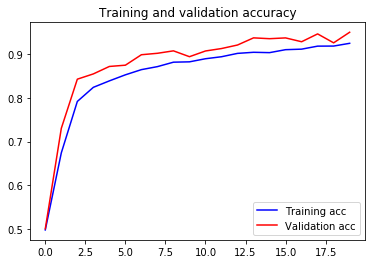

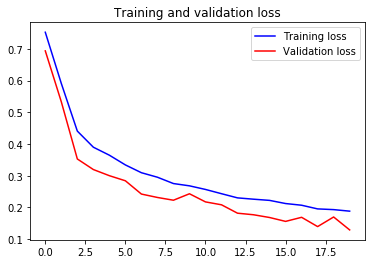

In [23]:
#
#  Mostra a variação da perda e da acurária ao longo das épocas
#

show_charts(history_b1)

In [24]:
#
# Visualização do modelo 2
# 

show_model(model_1, '2')

Resumo do modelo 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 32)        9248      
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 5, 5, 32)          0 

## Terceiro Modelo 
### Treinando a parte B com fine tunning na ultima camada 

_Fine-tuning_ em uma camada: Utilizar os pesos da rede treinada na parte A e realizar
_fine-tuning_ na ultima camada _Fully Connected_.

In [0]:
#
#  Definição do modelo 3
#

model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))

model_3.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_3.add(Conv2D(32, (3, 3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))
model_3.add(Dropout(0.3))

model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.3))

model_3.add(Dense(10, activation='softmax', name="fully_conected_2", trainable=False))
model_3.load_weights('part_a_weights.h5', by_name=True)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_3.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [26]:
history_b2 = model_3.fit(x_train_b, y_train_b, batch_size=32, epochs=NUM_EPOCHS, validation_data=(x_test_b, y_test_b))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 3s 271us/step - loss: 1.6523 - acc: 0.3129 - val_loss: 0.7019 - val_acc: 0.5000
Epoch 2/20
10000/10000 [==============================] - 2s 219us/step - loss: 0.8037 - acc: 0.4911 - val_loss: 0.6937 - val_acc: 0.6007
Epoch 3/20
10000/10000 [==============================] - 2s 219us/step - loss: 0.7962 - acc: 0.4939 - val_loss: 0.6942 - val_acc: 0.5000
Epoch 4/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.7850 - acc: 0.5104 - val_loss: 0.6573 - val_acc: 0.6488
Epoch 5/20
10000/10000 [==============================] - 2s 218us/step - loss: 0.6946 - acc: 0.6372 - val_loss: 0.4979 - val_acc: 0.7585
Epoch 6/20
10000/10000 [==============================] - 2s 218us/step - loss: 0.5638 - acc: 0.7411 - val_loss: 0.5726 - val_acc: 0.7175
Epoch 7/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.5040 - acc: 0.7737 - val_loss: 0.3922 - 

### Visualizando os resultados do modelo 3

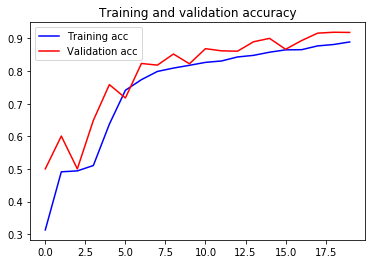

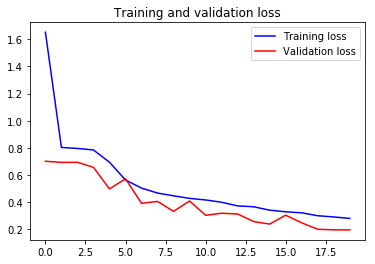

In [27]:
#
#  Mostra a variação da perda e da acurária ao longo das épocas
#

show_charts(history_b2)

In [28]:
#
# Visualização do modelo 3
# 

show_model(model_1, '3')

Resumo do modelo 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 32)        9248      
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 5, 5, 32)          0 

## Quarto Modelo - Treinando a parte B com fine tunning nas camadas de Fuly Connected

In [0]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

model_4.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model_4.add(Conv2D(32, (3, 3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))
model_4.add(Dropout(0.3))

model_4.add(Flatten())
model_4.add(Dense(256, activation='relu', name="fully_conected_1", trainable=False))
model_4.add(Dropout(0.3))

model_4.add(Dense(10, activation='softmax', name="fully_conected_2", trainable=False))
model_4.load_weights('part_a_weights.h5', by_name=True)

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_4.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [30]:
history_b3 = model_2.fit(x_train_b, y_train_b, batch_size=32, epochs=NUM_EPOCHS, validation_data=(x_test_b, y_test_b))

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 3s 255us/step - loss: 0.1875 - acc: 0.9216 - val_loss: 0.1128 - val_acc: 0.9600
Epoch 2/20
10000/10000 [==============================] - 2s 222us/step - loss: 0.1753 - acc: 0.9284 - val_loss: 0.1116 - val_acc: 0.9604
Epoch 3/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.1671 - acc: 0.9287 - val_loss: 0.1135 - val_acc: 0.9599
Epoch 4/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.1642 - acc: 0.9318 - val_loss: 0.1013 - val_acc: 0.9645
Epoch 5/20
10000/10000 [==============================] - 2s 217us/step - loss: 0.1602 - acc: 0.9340 - val_loss: 0.1028 - val_acc: 0.9681
Epoch 6/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.1541 - acc: 0.9361 - val_loss: 0.1009 - val_acc: 0.9685
Epoch 7/20
10000/10000 [==============================] - 2s 216us/step - loss: 0.1509 - acc: 0.9392 - val_loss: 0.0839 - 

### Visualizando os resultados do modelo 4

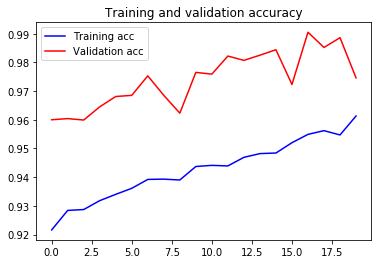

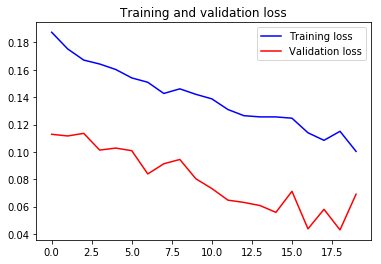

In [31]:
#
#  Mostra a variação da perda e da acurária ao longo das épocas
#

show_charts(history_b3)

In [32]:
#
# Visualização do modelo 4
# 

show_model(model_1, '4')

Resumo do modelo 4
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
conv_2 (Conv2D)              (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling_1 (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 12, 12, 32)        9248      
_________________________________________________________________
conv_4 (Conv2D)              (None, 10, 10, 32)        9248      
_________________________________________________________________
max_pooling_2 (MaxPooling2D) (None, 5, 5, 32)          0 

## Comparações e conclusões

A estratégia de fine-tuning consiste em dar continuidade ao treinamento de uma rede
pretreinada. É possível fazer o fine-tuning de todas as camadas de uma CNN, ou somente das
últimas camadas. Isso é motivado pelo fato que as primeiras camadas da rede contém extratores
mais genéricos que podem ser utilizados para diferentes tarefas, como detectores
de bordas e de cores, porém, as camadas mais profundas possuem detalhes específicos da
base com a qual a rede foi originalmente treinada.

Neste trabalho foi feito o fine tunning na última camada de Fully Connected e também outra vez, nas duas últimas camadas.
Pelos resultados obtidos podemos observar que em primeiro lugar, em todas as estratégias houve uma redução da perda durante as épocas e um aumento da acurácia (de forma geral). O melhor desempenho percebido com no modelo 4 com o uso de Fine tunning nas duas camadas de Fully Connected. Aparentemente a utilização de fine tunning obteve um melhor resultado.

Em relação à regularização, foi possível notar que a função de perda diminui a medida que a acurária aumenta. 

# Referências

* Base de dados
  * https://www.cs.toronto.edu/~kriz/cifar.html 
    
* Referências técnicas
  * https://keras.io/
  * https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers
  * https://machinelearningmastery.com/save-load-keras-deep-learning-models/
  * https://matplotlib.org/gallery/index.html
  * https://keras.io/visualization/
  